# Notebook for exercise 1 

ΚΟΥΝΣΟΛΑΣ ΧΡΗΣΤΟΣ

10345

ΤΗΜΜΥ

- This notebook contains the `task_1`, where a build a Neural Network for the classification of the `CIFAR-10` dataset.
- Then i compare the Neural Network acuracy with the KNN, NCC classifiers accuracy, that i had in the `task_0`.
- I tried to achieve a good enough accuracy with many models, but because `CIFAR-10` is a challenging dataset, the MLP models won't have a high accuracy percentage.
- That's why i will try and build a Convolutional Neural Networks which is more ideal for this kind of dataset

For `task_1` i watched this tutorial:

https://www.youtube.com/watch?v=V_xro1bcAuA&t=25243s&ab_channel=freeCodeCamp.org

so my models are constructed in a similar way.



# MLPs models

So at first i will try to build MLP (Multi-Layer Perceptrons) model . These models are described as Multi-Layer Perceptron (MLP). An MLP is a type of feedforward neural network consisting of input, hidden and output layers. I know though that MLP is less effective for image classification problems. So let's see how well the following models perform.

## 0. Get data ready and import the necessary libraries

In [161]:
# Import the necessary libraries
import os   #helps me erase a warning that i am getting
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler  #need this for standardizing the data
from sklearn.decomposition import PCA #need this for the PCA in the data
import torch
from torch import nn #need this for my model (layers, loss functions, ...)
from sklearn.metrics import accuracy_score #need this to measure the accuracy of the model
import time  #need this to calcualate the training time
from pathlib import Path #need this for the save_model(). 
import matplotlib.pyplot as plt  # need this for the model's plots
import pandas as pd




### 0.1 Create train and test sets



In [162]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



### 0.2 Preprocessing the Data
From `task_0`, I am going to use:
* **StandardScaler**

The `StandardScaler` is a preprocessing technique that transforms data to have a mean of 0 and a standard deviation of 1.


* **PCA**

The `Principal Component Analysis (PCA)` is a dimensionality reduction technique used to simplify datasets by projecting them onto a set of orthogonal axes called principal components. These components capture the maximum variance in the data while reducing its dimensionality. 
From 3072 dimensions with PCA i will get to 100 dimensions. 
This speeds up computations

I have seen from the previous exercise that these two combined, improve the accuracy of the model

In [163]:
#Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train) #find the mean and standard deviation from X_train and then scale it to have mean=0 and std=1.
X_test = sc_X.transform(X_test) # !!! use the mean and std found from X_train to scale the X_test

#PCA
pca = PCA(n_components=100)  #i will keep the 100 features with the most variance
X_train = pca.fit_transform(X_train)  #find the 100 principal components and keeps only these components
X_test = pca.transform(X_test)   #Keeps the equivalent components with the X_train

# if i run this code cell twice, my data are already tensors and i get an error.
# With the try except i overcome this error
try:
    # Turn data into tensors
    X_train = torch.from_numpy(X_train).type(torch.float)
    X_test = torch.from_numpy(X_test).type(torch.float)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    y_test = torch.from_numpy(y_test).type(torch.LongTensor)
    print("Data successfully converted to tensors.")
except TypeError:
    print("Data are already tensors.")







Data successfully converted to tensors.


In [164]:
#print the shapes of the data to be sure that everything went well
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: torch.Size([50000, 100])
y_train shape: torch.Size([50000])
X_test shape: torch.Size([10000, 100])
y_test shape: torch.Size([10000])


### 0.3 Device agnostic code

This well help me ran the code faster if a gpu is available.

In [165]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 0.4 Evaluation Function

In [166]:
def eval_model(model,X_test,y_test,device,optimizer,loss_fn,epochs:int):
    
    loss_sum=0
    #Send the X_test to device
    X_test = X_test.to(device)
    
    for epoch in range(epochs):
        model.eval()
        with torch.inference_mode():
            y_logits=model(X_test)
            loss_sum +=loss_fn(y_logits,y_test)
            y_pred=y_logits.argmax(dim=1)
            acc = accuracy_score(y_true=y_test.cpu(),y_pred=y_pred.cpu())

    return {
        "model_name":model.__class__.__name__,
        "model loss per epoch":loss_sum.item()/epochs,
        "model accuracy":acc
    }

# 1. Build a linear model

* I know that the problem of the classification of the CIFAR-10 dataset is non linear, but i want to see how well a linear model performs.
* The `model1_linear` is my linear model, with 2 hidden layers and 512 hidden units for each one of them

### 1.1 Build a linear model



In [167]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use only linear layers (No ReLU)
class linear_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model1_linear = linear_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model1_linear

linear_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Create Loss function and Optimizer

* I am wokring on a multiclass classification problem, so i will use the `nn.CrossEntropyLoss()` method as my loss function.
* For the optimizer i will use the Stochastic Gradient Descent (`SGD`)

In [168]:
loss_fn = nn.CrossEntropyLoss()  # measures how wrong are my predictions
optimizer = torch.optim.SGD(params = model1_linear.parameters(),  #changes the parameters of the model to make the model's predicions better
                            lr=0.01)


### 1.3 Create train and test loop function

In [169]:
#put the data to target device (in my case the gpu)
#this will make my code run faster
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [170]:
class my_Metrics:
    def __init__(self, epochs):
        self.epochs = epochs
        self.train_loss_values = np.full((epochs), np.nan)
        self.test_loss_values = np.full((epochs), np.nan)
        self.train_acc_values = np.full((epochs), np.nan)
        self.test_acc_values = np.full((epochs), np.nan)

    def reset(self):
        self.train_loss_values[:] = np.nan
        self.test_loss_values[:] = np.nan
        self.train_acc_values[:] = np.nan
        self.test_acc_values[:] = np.nan
    

Below is the function that implements the trainig and testing of the model. For each `epoch` i do the following:

* For the training:
1. Put my model inn training mode
1. Do the Forward pass
2. Calculate the train loss and train accuracy of the model in this epoch using the loss function that i have chosen and the `accuracy_score()` from `sklearn.metrics`
3. Set the optimizers gradients to 0
4. Do the BackPropagation, sending the loss back to all the layers and neurons
5. With `optimizer.step()` update the parameters of my model

* For the testing:
1. Put the model in evaluation mode
2. Do the forward pass
3. Calculate the test loss and test accuracy


In [171]:
def train_test_fn(model,epochs,X_train,X_test,y_train,y_test,metrics,device,optimizer,loss_fn):  #model will run in gpu except i say to run on cpu
    metrics.reset() # Reset metrics before each call
    start_time = time.time()  # Start the timer

    #send the model and the data to the device (gpu if available)
    model.to(device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)
    
    for epoch in range(epochs):
        ### Training
        model.train()  #put the model in training mode
        #1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1) # logits -> pred probabilities -> pred labels
        #2. Calculate loss and accuracy
        loss = loss_fn(y_logits,y_train)
        metrics.train_loss_values[epoch] = loss
        acc = accuracy_score(y_train.cpu(),y_pred.cpu())
        metrics.train_acc_values[epoch] = acc
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backwards
        loss.backward()
        #5.Optimizer step
        optimizer.step()
    
        ###Testing
        #put the model in evaluation mode
        model.eval()
        with torch.inference_mode():
            #1. Forward pass
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            #2. Calculate the test loss and accuracy
            test_loss = loss_fn(test_logits,y_test)
            metrics.test_loss_values[epoch] = test_loss
            test_acc = accuracy_score(y_test.cpu(),test_pred.cpu())
            metrics.test_acc_values[epoch] = test_acc

        #Print the results
        if epoch % (epochs//10) == 0 or epoch == epochs-1:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

    end_time = time.time()  # End the timer
    total_time = end_time - start_time  # Calculate total time
    print(f"Training completed in: {total_time:.2f} seconds")





In [172]:
epochs =300

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model1_linear,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics, 
              device=device,
              optimizer=optimizer,
              loss_fn=loss_fn
              )

Epoch: 0 | Loss: 2.93398, Acc: 0.08 | Test Loss: 2.40584, Test Acc: 0.16
Epoch: 30 | Loss: 1.90209, Acc: 0.33 | Test Loss: 1.90159, Test Acc: 0.33
Epoch: 60 | Loss: 1.83581, Acc: 0.36 | Test Loss: 1.83709, Test Acc: 0.36
Epoch: 90 | Loss: 1.80551, Acc: 0.38 | Test Loss: 1.80746, Test Acc: 0.38
Epoch: 120 | Loss: 1.78778, Acc: 0.39 | Test Loss: 1.79022, Test Acc: 0.38
Epoch: 150 | Loss: 1.77600, Acc: 0.39 | Test Loss: 1.77883, Test Acc: 0.39
Epoch: 180 | Loss: 1.76755, Acc: 0.39 | Test Loss: 1.77071, Test Acc: 0.39
Epoch: 210 | Loss: 1.76121, Acc: 0.39 | Test Loss: 1.76462, Test Acc: 0.39
Epoch: 240 | Loss: 1.75630, Acc: 0.40 | Test Loss: 1.75990, Test Acc: 0.39
Epoch: 270 | Loss: 1.75241, Acc: 0.40 | Test Loss: 1.75614, Test Acc: 0.40
Epoch: 299 | Loss: 1.74936, Acc: 0.40 | Test Loss: 1.75319, Test Acc: 0.40
Training completed in: 10.25 seconds


### 1.4 Save the `model1_linear` in `Ex1_Models` folder

I am saving the model's parameters in case i want to load this model. This way i wont have to call again the `train_test_fn()` which takes some time.

In [173]:
# create a function to save the model to a folder called `Ex1_models`
def save_model(model,model_name):
    #1. Create models directory
    MODEL_PATH = Path("Ex1_Models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    #2. Create model save path
    MODEL_NAME = model_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    #3. save the model state dict
    print(f"Saving model to:{MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)


In [174]:
save_model(model=model1_linear,
           model_name="model1_linear.pth")

Saving model to:Ex1_Models\model1_linear.pth


### 1.5 Plot and evaluate the `model1_liner` 

In [175]:
def plot_loss_acc_fn(metrics,model_name):
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(metrics.train_loss_values,label="Train Loss")
    plt.plot(metrics.test_loss_values,label="Test Loss")
    plt.title("Train Loss vs Test Loss (" + model_name + ")" ,fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(metrics.train_acc_values,label="Train Accuaracy")
    plt.plot(metrics.test_acc_values,label="Test Accuracy")
    plt.axhline(y=0.4425,color='r',ls='--',label="Best accuracy from Task_0")  #the best accuracy achieved from Task_0 (3NN)
    plt.title("Train Accuracy vs Test Accuracy",fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
    

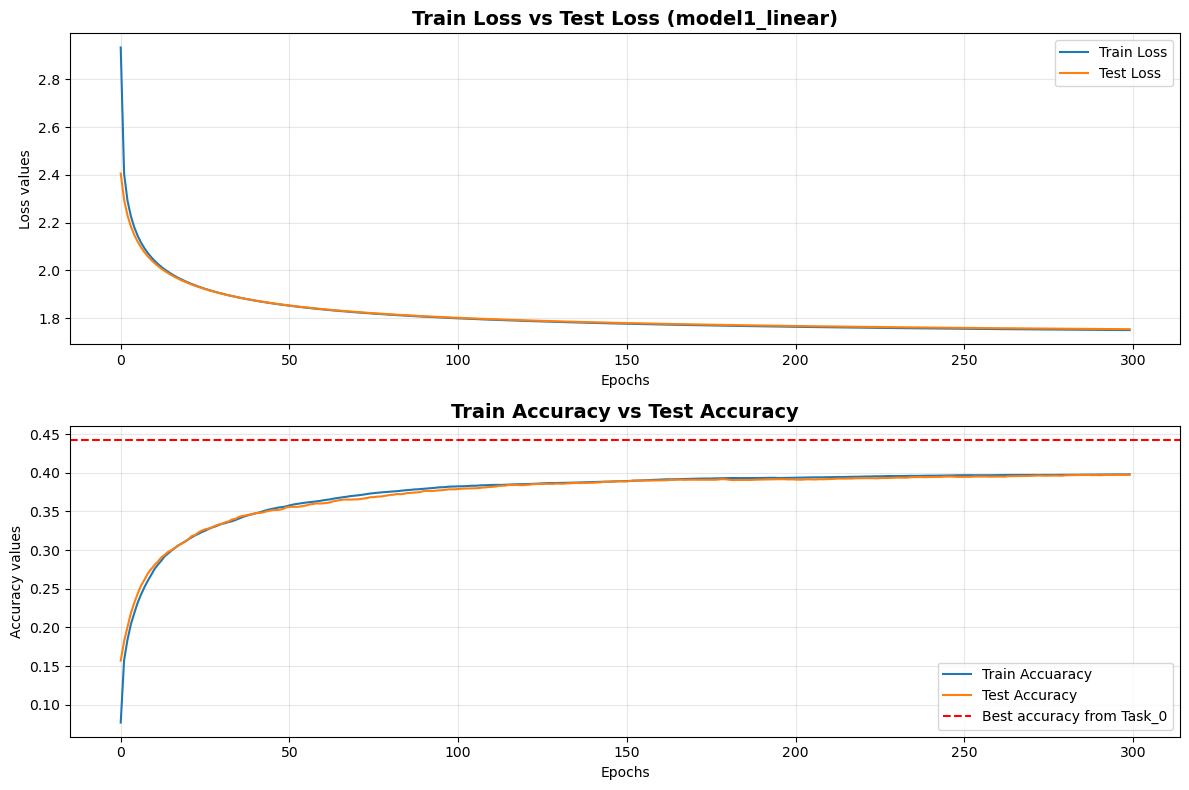

In [176]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model1_linear")

In [177]:
model1_linear_results = eval_model(model=model1_linear,
                                   X_test=X_test,
                                   y_test=y_test,
                                   device=device,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=300
                                  )
model1_linear_results

{'model_name': 'linear_model',
 'model loss per epoch': 1.753180948893229,
 'model accuracy': 0.3973}

### 1.6. Conclusion

- For my first attempt i used a linear model with 2 hidden layers and each hidden layer with 512 hidden units (neurons).
- Despite 300 epochs, the training accuracy only reaches about 0.4% and the test accuracy is similar. This suggests that the model is not learning effectively.
- I expected this, because my problem is not linear and i am using a linear model.

## 2. Build a non linear model

I have a non linear multiclass classification problem , so a will need a non linear MLP. To implement the non linearity i will use the `ReLU`. 

This functions gets an input and outputs the input number if its greater than 0. Else `ReLU` outputs 0

This function is shown below.


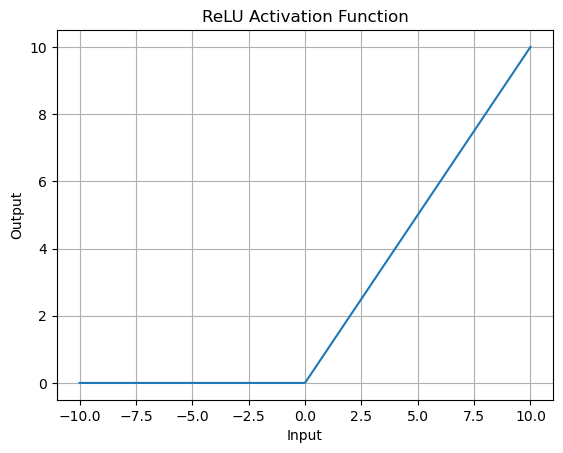

In [178]:
# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate input data
x = np.linspace(-10, 10, 400)

# Plot the ReLU function
plt.plot(x, relu(x), label="ReLU")
plt.title("ReLU Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)
plt.show()

### 2.1 Create model

Below i have a feedforward neural network with 2 hidden layers and each hidden layer has 512 hidden units. Each hidden layer has a non linear activation function, the `ReLU` , that helps the model capture complex patterns. 

In [179]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class relu_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(  #nn.Sequential -> straightforward feedforward models
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model2_relu = relu_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model2_relu

relu_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 2.2 Loss function and optimizer

- Loss function: `nn.CrossEntropyLoss()` suitable for multiclass classification tasks
- Optimizer: `torch.optim.SGD`, updates model parameters to minimimze the loss using Stochastic Gradient Descent

In [180]:
#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model2_relu.parameters(),
                            lr=0.01)

### 2.3 Train and test loop

In [181]:
# call train_test_fn to train and test my model
epochs = 1000

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model2_relu,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics, 
              device=device,
              optimizer=optimizer,
              loss_fn=loss_fn
             )

Epoch: 0 | Loss: 2.42246, Acc: 0.12 | Test Loss: 2.35852, Test Acc: 0.12
Epoch: 100 | Loss: 1.86887, Acc: 0.35 | Test Loss: 1.86901, Test Acc: 0.35
Epoch: 200 | Loss: 1.76145, Acc: 0.39 | Test Loss: 1.76602, Test Acc: 0.38
Epoch: 300 | Loss: 1.70059, Acc: 0.41 | Test Loss: 1.70812, Test Acc: 0.40
Epoch: 400 | Loss: 1.65791, Acc: 0.42 | Test Loss: 1.66856, Test Acc: 0.41
Epoch: 500 | Loss: 1.62462, Acc: 0.44 | Test Loss: 1.63875, Test Acc: 0.43
Epoch: 600 | Loss: 1.59708, Acc: 0.45 | Test Loss: 1.61494, Test Acc: 0.43
Epoch: 700 | Loss: 1.57344, Acc: 0.45 | Test Loss: 1.59512, Test Acc: 0.44
Epoch: 800 | Loss: 1.55259, Acc: 0.46 | Test Loss: 1.57815, Test Acc: 0.45
Epoch: 900 | Loss: 1.53384, Acc: 0.47 | Test Loss: 1.56332, Test Acc: 0.45
Epoch: 999 | Loss: 1.51690, Acc: 0.47 | Test Loss: 1.55020, Test Acc: 0.46
Training completed in: 38.00 seconds


### 2.4 Save the `model2_relu`

In [182]:
save_model(model=model2_relu,
           model_name="model2_relu.pth")

Saving model to:Ex1_Models\model2_relu.pth


### 2.5 PLot and evaluate the `model2_relu`

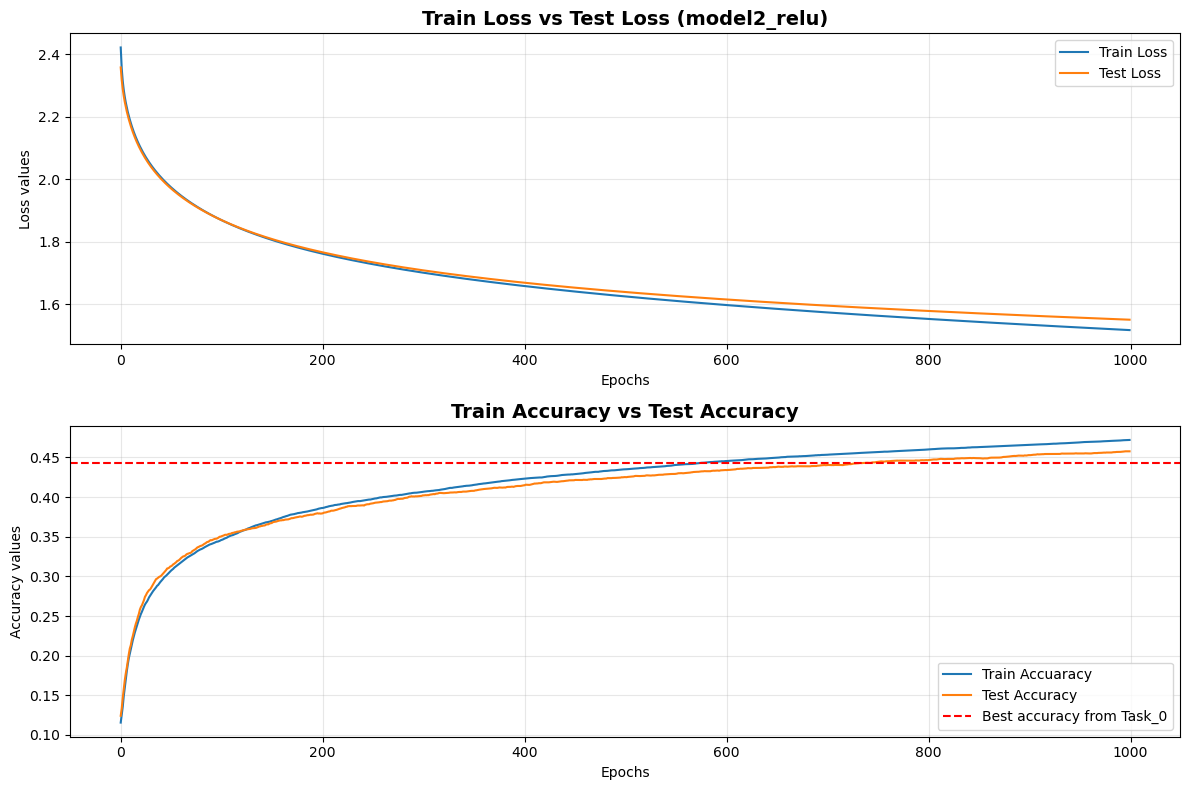

In [183]:
plot_loss_acc_fn(metrics,"model2_relu")

In [184]:
model2_relu_results = eval_model(model=model2_relu,
                                   X_test=X_test,
                                   y_test=y_test,
                                   device=device,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=1000
                                  )
model2_relu_results

{'model_name': 'relu_model',
 'model loss per epoch': 1.5502012939453125,
 'model accuracy': 0.4577}

### 2.6 Conclusion for `model2_relu`

As expected the non linear model performs better than the linear one, because we have a non linear problem. From the last graph i can see that the acuuracy of this model is higher than  the best accuracy achieved in Task_0.

So i achieved this performance with only 2 hidden layers and 512 hidden units.

What would happen if i had a deeper (more hidden layers) and a wider (more hidden units) non linear model ?

Let's try this


## 3 Build a wider and deeper non linear model 

Now i will try to build a non linear model with 5 hidden layers and 1024 hidden units to see if it performs better. I have a large dataset so, i believe that a deeper model will be more efficient dealing with complex patterns that exist in CIFAR-10 dataset

### 3.1 Create model

In [185]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class deep_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model3_deep = deep_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model3_deep

deep_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

### 3.2 Loss function and optimizer

In [186]:
#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model3_deep.parameters(),
                            lr=0.01)

### 3.3 train and test loop

In [187]:
# call train_test_fn to train and test my model
epochs =500

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model3_deep,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics,
              device=device,
              optimizer=optimizer,
              loss_fn=loss_fn
)

Epoch: 0 | Loss: 2.30172, Acc: 0.09 | Test Loss: 2.30131, Test Acc: 0.10
Epoch: 50 | Loss: 2.28864, Acc: 0.17 | Test Loss: 2.28797, Test Acc: 0.18
Epoch: 100 | Loss: 2.27251, Acc: 0.20 | Test Loss: 2.27145, Test Acc: 0.21
Epoch: 150 | Loss: 2.24877, Acc: 0.21 | Test Loss: 2.24716, Test Acc: 0.22
Epoch: 200 | Loss: 2.21222, Acc: 0.24 | Test Loss: 2.20987, Test Acc: 0.24
Epoch: 250 | Loss: 2.15970, Acc: 0.26 | Test Loss: 2.15655, Test Acc: 0.26
Epoch: 300 | Loss: 2.09698, Acc: 0.27 | Test Loss: 2.09319, Test Acc: 0.28
Epoch: 350 | Loss: 2.03705, Acc: 0.29 | Test Loss: 2.03296, Test Acc: 0.29
Epoch: 400 | Loss: 1.98573, Acc: 0.30 | Test Loss: 1.98148, Test Acc: 0.30
Epoch: 450 | Loss: 1.94274, Acc: 0.31 | Test Loss: 1.93847, Test Acc: 0.32
Epoch: 499 | Loss: 1.90746, Acc: 0.32 | Test Loss: 1.90319, Test Acc: 0.33
Training completed in: 187.67 seconds


### 3.4 save the `model3_deep`

In [188]:
save_model(model=model3_deep,
           model_name="model3_deep.pth")

Saving model to:Ex1_Models\model3_deep.pth


### 3.5 Plot and evaluate  the `model3_deep`

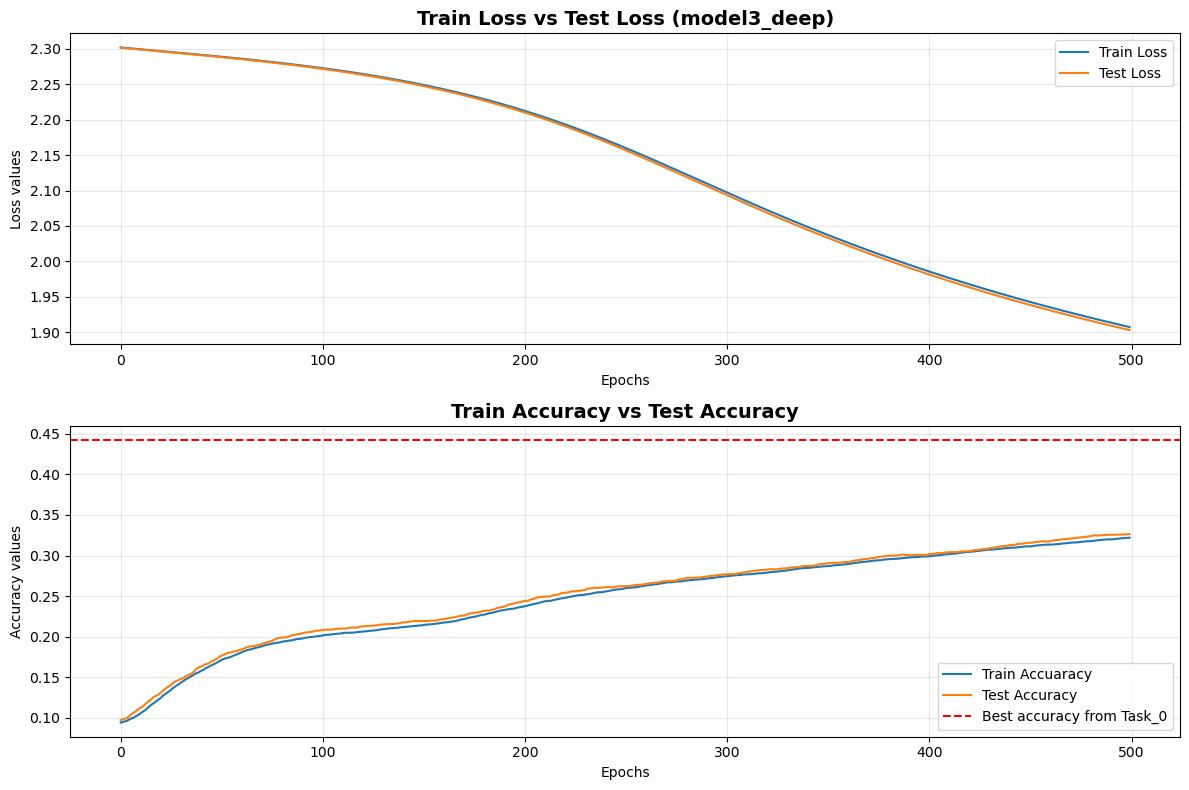

In [189]:
plot_loss_acc_fn(metrics=metrics,
                model_name="model3_deep")

In [190]:
model3_deep_results = eval_model(model=model3_deep,
                                   X_test=X_test,
                                   y_test=y_test,
                                   device=device,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=500
                                  )
model3_deep_results

{'model_name': 'deep_model',
 'model loss per epoch': 1.903197998046875,
 'model accuracy': 0.3264}

### 3.6 Conclusion for `model3_relu_layers`

- From the graphs i can see that my model is learning but in a very slow rate.
- Through 500 epochs the accuracy is less than what i thought i would get, but from the last graph, i can say that if i trained my model for more epochs, the accuracy was going to be higher.

So lets try to make the convergence of this model faster.

## 4. Model with Momentum and Batch Normalization

I will keep the same structure as above but since i want to make the convergence faster, i will also implement `Momentum` in my optimizer and i will add `Batch Normalization` to normalize the inputs of each layer during training in order to have mean of 0 and a variance of 1.

* Momentum prevents the model from getting stuck in unhelpfull updates by maintaining the direction of the previous steps.
* Normalizing the input of each layer, reduces the risk of exploding or vanishing gradients and prevents the model from getting stuck in a local minima
  
Let's see if the above make the convergence faster and as a result improve the accuracy

### 4.1 Create a model

In [191]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class norma_mom_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model4_norma_mom = norma_mom_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model4_norma_mom,device

(norma_mom_model(
   (linear_layer_stack): Sequential(
     (0): Linear(in_features=100, out_features=1024, bias=True)
     (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Linear(in_features=1024, out_features=1024, bias=True)
     (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU()
     (6): Linear(in_features=1024, out_features=1024, bias=True)
     (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU()
     (9): Linear(in_features=1024, out_features=1024, bias=True)
     (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): ReLU()
     (12): Linear(in_features=1024, out_features=1024, bias=True)
     (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (14): ReLU()
     (15): Linear(in_features=1024, out_features=1024, bias=True)
     

### 4.2 Loss function and optimizer 



In [192]:
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model4_norma_mom.parameters(),lr=0.01,momentum=0.9)

### 4.3 Train and test loop

In [193]:
# call train_test_fn to train and test my model
epochs =300

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model4_norma_mom,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics,
              device=device,
              optimizer=optimizer,
              loss_fn=loss_fn
)

Epoch: 0 | Loss: 2.35239, Acc: 0.11 | Test Loss: 2.30253, Test Acc: 0.11
Epoch: 30 | Loss: 1.44884, Acc: 0.50 | Test Loss: 1.73586, Test Acc: 0.40
Epoch: 60 | Loss: 1.11151, Acc: 0.63 | Test Loss: 1.42239, Test Acc: 0.50
Epoch: 90 | Loss: 0.79402, Acc: 0.76 | Test Loss: 1.39392, Test Acc: 0.51
Epoch: 120 | Loss: 0.48242, Acc: 0.89 | Test Loss: 1.43852, Test Acc: 0.52
Epoch: 150 | Loss: 0.23757, Acc: 0.97 | Test Loss: 1.54965, Test Acc: 0.51
Epoch: 180 | Loss: 0.10417, Acc: 1.00 | Test Loss: 1.69539, Test Acc: 0.51
Epoch: 210 | Loss: 0.05102, Acc: 1.00 | Test Loss: 1.83105, Test Acc: 0.50
Epoch: 240 | Loss: 0.03030, Acc: 1.00 | Test Loss: 1.93652, Test Acc: 0.50
Epoch: 270 | Loss: 0.02065, Acc: 1.00 | Test Loss: 2.01599, Test Acc: 0.50
Epoch: 299 | Loss: 0.01546, Acc: 1.00 | Test Loss: 2.07655, Test Acc: 0.50
Training completed in: 163.79 seconds


### 4.4 Save the `model4_norma_mom`

In [194]:
save_model(model=model4_norma_mom,
           model_name="model4_norma_mom.pth")

Saving model to:Ex1_Models\model4_norma_mom.pth


### 4.5 Plot and evaluate the `model4_norma_mom`

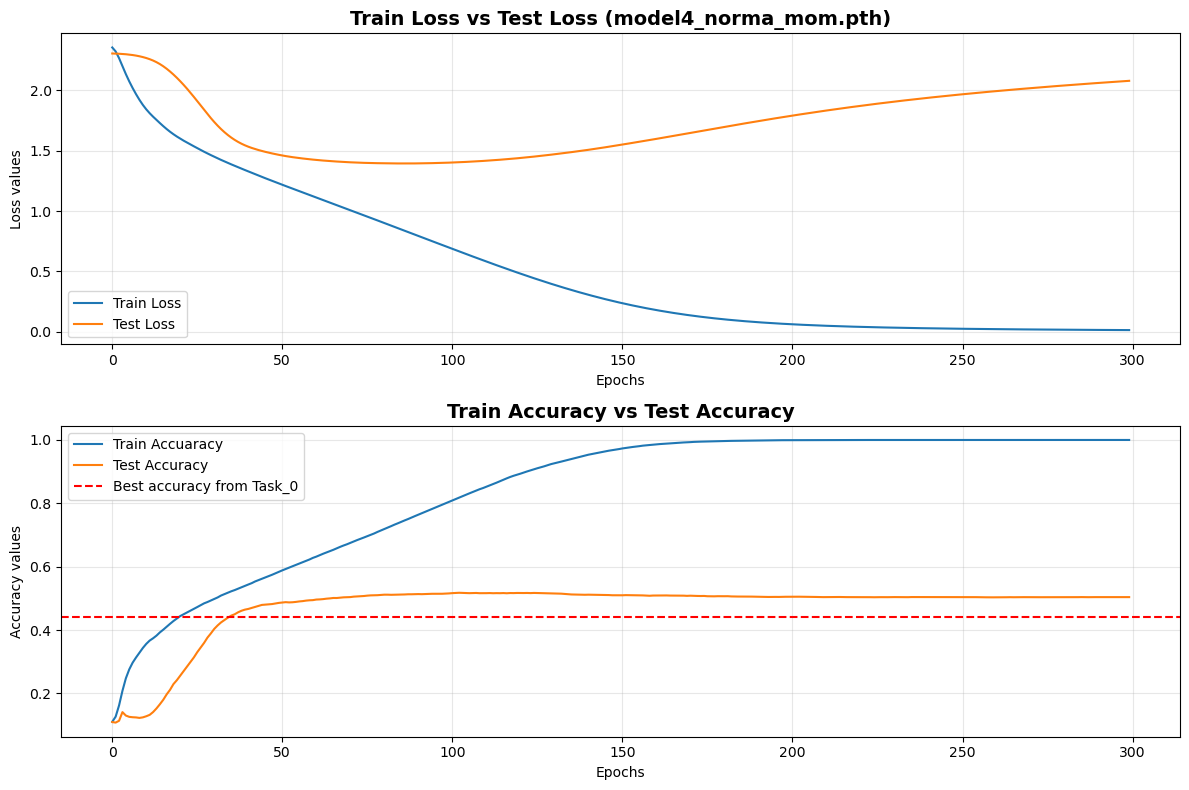

In [195]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model4_norma_mom.pth")

In [196]:
model4_norma_mom_results = eval_model(model=model4_norma_mom,
                                   X_test=X_test,
                                   y_test=y_test,
                                   device=device,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=300
                                  )
model4_norma_mom_results

{'model_name': 'norma_mom_model',
 'model loss per epoch': 2.07654296875,
 'model accuracy': 0.504}

### 4.6 Conclusion for `model4_norma_mom`

I notice that the convergence of this model is faster than the previous model (`mode3_deep`), but i have overfitting. To prevent this in my next model i will also use `dropout`.

## 5. Build model 

In this model i will use:
- Momentum
- Batch Normalization

and to prevent overfitting i will also use
- Dropout

Dropout randomly sets to 0 a fractiion of the neurons in the network. This prevents the model from relying too much on a neuron, making it learn more robust features.It is a  technique to manage overfitting by introducing randomness during training, improving the model's ability to generalize to unseen data.

### 5.1 Create a model

In [197]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class dropout_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model5_dropout = dropout_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model5_dropout

dropout_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=1024, out_features=1024, bias=True)
    (17): BatchNorm1d(1024, eps=1e-05, 

### 5.2 Loss Function and optimizer

In [198]:
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model5_dropout.parameters(),lr=0.01,momentum=0.9)

### 5.3 Train and test loop

In [199]:
epochs=500
# Create a metrics object
metrics = my_Metrics(epochs)

train_test_fn(model=model5_dropout,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics,
              device=device,
              optimizer=optimizer,
              loss_fn=loss_fn
)

Epoch: 0 | Loss: 2.39218, Acc: 0.10 | Test Loss: 2.30214, Test Acc: 0.11
Epoch: 50 | Loss: 1.74648, Acc: 0.37 | Test Loss: 1.81695, Test Acc: 0.36
Epoch: 100 | Loss: 1.59738, Acc: 0.42 | Test Loss: 1.62353, Test Acc: 0.43
Epoch: 150 | Loss: 1.51963, Acc: 0.45 | Test Loss: 1.54595, Test Acc: 0.46
Epoch: 200 | Loss: 1.45979, Acc: 0.48 | Test Loss: 1.49633, Test Acc: 0.48
Epoch: 250 | Loss: 1.41080, Acc: 0.49 | Test Loss: 1.45944, Test Acc: 0.49
Epoch: 300 | Loss: 1.37141, Acc: 0.51 | Test Loss: 1.43082, Test Acc: 0.51
Epoch: 350 | Loss: 1.33915, Acc: 0.52 | Test Loss: 1.40602, Test Acc: 0.51
Epoch: 400 | Loss: 1.30401, Acc: 0.53 | Test Loss: 1.38641, Test Acc: 0.52
Epoch: 450 | Loss: 1.27168, Acc: 0.54 | Test Loss: 1.37065, Test Acc: 0.53
Epoch: 499 | Loss: 1.24996, Acc: 0.55 | Test Loss: 1.35823, Test Acc: 0.53
Training completed in: 975.50 seconds


### 5.4 Save the `model5_dropout`

In [200]:
save_model(model=model5_dropout,model_name="model5_dropout.pth")

Saving model to:Ex1_Models\model5_dropout.pth


### 5.5 Plot and evaluate the `model5_dropout`

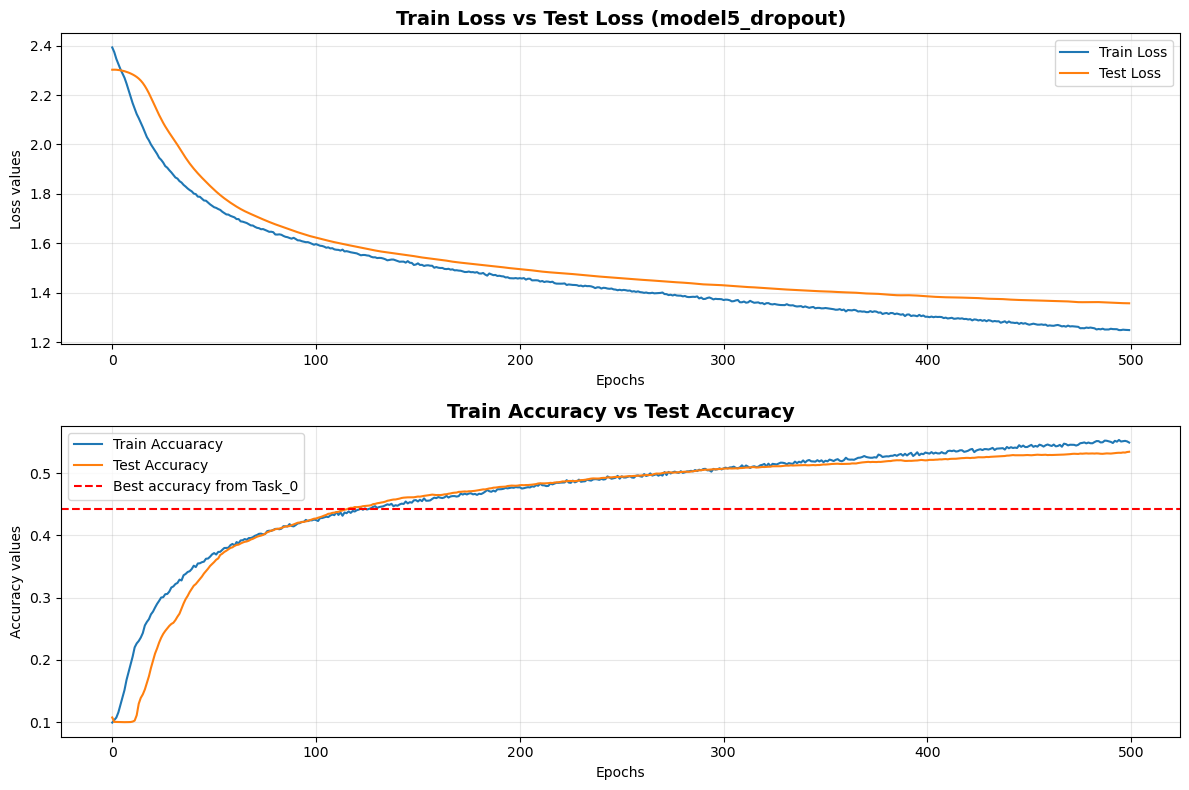

In [201]:
plot_loss_acc_fn(metrics=metrics,model_name="model5_dropout")

In [202]:
model5_dropout_results = eval_model(model=model5_dropout,
                                   X_test=X_test,
                                   y_test=y_test,
                                   device=device,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=500
                                  )
model5_dropout_results

{'model_name': 'dropout_model',
 'model loss per epoch': 1.358233642578125,
 'model accuracy': 0.5342}

### 5.6 Conclusion for `model5_dropout` and `MLPs`

- Adding the dropout at each hidden layer of the same model that i had before (`model4_norma_mom`), prevented the overfitting, made my model's training time much slower though.
- Looking at the two plots, i can say that this is the best MLP model that i have, but i can also say that the performance of this model isn't good enough for our classification problem.
- This was expected as i knew that MLPs are less effective for these kinds of problems.
- On the other hand Convolutional Neural Networks perform better. Next up let's see how CNNs perform for the same problem

In [203]:
compare_results=pd.DataFrame([model1_linear_results,model2_relu_results,model3_deep_results,model4_norma_mom_results,model5_dropout_results])
compare_results

,model_name,model loss per epoch,model accuracy
0,linear_model,1.753181,0.3973
1,relu_model,1.550201,0.4577
2,deep_model,1.903198,0.3264
3,norma_mom_model,2.076543,0.5040
4,dropout_model,1.358234,0.5342


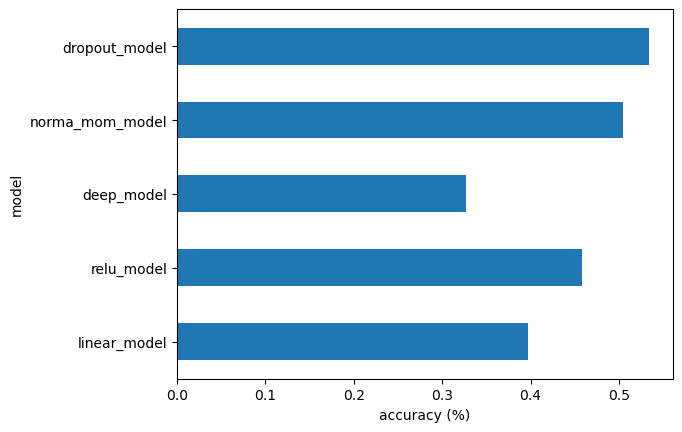

In [204]:
# Visualize our model results
compare_results.set_index("model_name")["model accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

* **Note**

  All the models above used the preprocessed data (`StandardScaler` and `PCA`) from `Task_0` having in mind that these data will make the training faster (since the features are 100 instead of 3072) and improve the accuracy since the classifiers from `Task_0` had benefited with these data. To be sure, below i will use the initial data for the best MLP model which is `model5_dropout`

In [205]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting
import numpy as np

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)

file_names.append("test_batch")

for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")

# Turn data into tensors
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



In [206]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

# Create an instance of model_1 and send it to the target device
model5_dropoutV2 = dropout_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)
        

#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model5_dropoutV2.parameters(),lr=0.1,momentum=0.95)
    

In [207]:
epochs=100
# Create a metrics object
metrics = my_Metrics(epochs)

train_test_fn(model=model5_dropoutV2,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics,
              device=device,
              optimizer=optimizer,
              loss_fn=loss_fn
)

Epoch: 0 | Loss: 2.36092, Acc: 0.10 | Test Loss: 2.29646, Test Acc: 0.10
Epoch: 10 | Loss: 1.73643, Acc: 0.38 | Test Loss: 2.20817, Test Acc: 0.15
Epoch: 20 | Loss: 1.51920, Acc: 0.46 | Test Loss: 1.64592, Test Acc: 0.42
Epoch: 30 | Loss: 1.39698, Acc: 0.50 | Test Loss: 1.53955, Test Acc: 0.45
Epoch: 40 | Loss: 1.29209, Acc: 0.54 | Test Loss: 1.39972, Test Acc: 0.51
Epoch: 50 | Loss: 1.19796, Acc: 0.57 | Test Loss: 1.37370, Test Acc: 0.52
Epoch: 60 | Loss: 1.11310, Acc: 0.60 | Test Loss: 1.32604, Test Acc: 0.54
Epoch: 70 | Loss: 1.03311, Acc: 0.63 | Test Loss: 1.62112, Test Acc: 0.49
Epoch: 80 | Loss: 0.97148, Acc: 0.65 | Test Loss: 1.68975, Test Acc: 0.48
Epoch: 90 | Loss: 0.91267, Acc: 0.67 | Test Loss: 1.93248, Test Acc: 0.46
Epoch: 99 | Loss: 0.84409, Acc: 0.70 | Test Loss: 1.75280, Test Acc: 0.48
Training completed in: 380.38 seconds


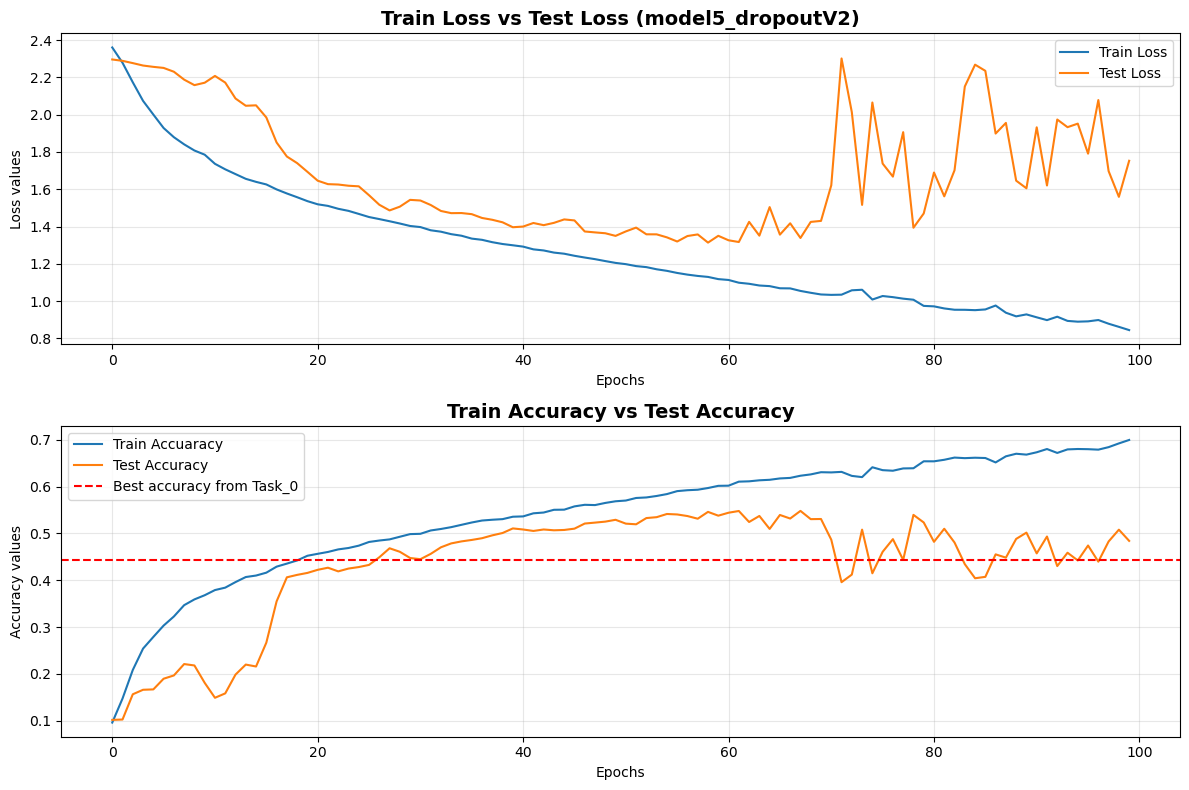

In [208]:
plot_loss_acc_fn(metrics=metrics,model_name="model5_dropoutV2")

As exepcted since i have 3072 features instead of 100 this model is much more time consuming than the `model5_dropout`. The performance also seems worse , since i have overfitting and the accuracy is lower.

#  CNN models

CNN's are known for their capabilities to find patterns in visual data and since we're dealing with visual data, let's see if using a CNN model can improve upon our previous MLP models. I have to say that the following section of the `task_1` (`CNN models`) was done done a bit hastily, but i wanted to include them in the report.

## Import the necessary libraries

In [209]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from pathlib import Path
import pandas as pd
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix



## Load the data and create device agnostic code

In [210]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)

file_names.append("test_batch")

for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")

# Turn data into tensors
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



'cuda'

### Get the class names of the `CIFAR-10` dataset 

In [211]:
# Path to the batches.meta file
meta_file_path = "C:/Users/xkoun/Documents/GitHub/NeuralNetworks/batches.meta"

# Load the meta file
with open(meta_file_path, 'rb') as f:
    meta = pickle.load(f, encoding='bytes')

# Extract the label names
class_names = [label.decode('utf-8') for label in meta[b'label_names']]

# Print the class names
print(class_names)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Convert the features from 3072 to [3, 32, 32]

In [212]:
# Reshape data from [3072] to [3, 32, 32]
#3=colours channels (red green blue)
#32=height
#32=width

X_train = X_train.view(-1, 3, 32, 32)
X_test = X_test.view(-1, 3, 32, 32)

# Create TensorDatasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Set up DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Check the dataloaders
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_features_labels = next(iter(test_dataloader))

#the shape of one batch
train_features_batch.shape, test_features_batch.shape


Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


(torch.Size([32, 3, 32, 32]), torch.Size([32, 3, 32, 32]))

### Show a sample from the train batch

Image size: torch.Size([32, 32, 3])
Label: 7, label size: torch.Size([])


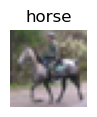

In [213]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()  

img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
# Permute the image dimensions
img = img.permute(1, 2, 0)/255.0  # Moves the channel dimension to the last because plot.imshow() gets the colour channels last
plt.figure(figsize=(1, 1))
plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Implement `train_step()`, `test_step()` and `eval_model()`

In [214]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y.cpu(),
                                 y_pred=y_pred.cpu().argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Dividing the total loss by the number of batches gives the average loss per batch for the epoch.
    train_loss /= len(data_loader)
    # Dividing the total accuracy by the number of batches gives the average accuracy per batch for the epoch.
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")
    return train_loss,train_acc

In [215]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y.cpu(),
                y_pred=test_pred.cpu().argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Dividing the total loss by the number of batches gives the average loss per batch for the epoch.  
        test_loss /= len(data_loader)
        # Dividing the total accuracy by the number of batches gives the average accuracy per batch for the epoch.
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")
        return test_loss,test_acc

In [216]:
def eval_model(model, data_loader, loss_fn,accuracy_fn,device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:   #looping over all the batches and all the images,labels of each batch
            X = X.to(device)
            y=y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y.cpu(), 
                                y_pred=y_pred.cpu().argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## 1.1 Create a convolutional neural network

For my first CNN model, i wont create a simple one, but a model that shares similarities with the MLP that achived the highest accuracy (`model5_dropout`). The simalirities are the implementation of the following:

- Momentum
- Batch Normalization
- Dropout

I am doing this because i hope that the above will result to a high accuracy for the CNN too.

Also i have to say that the structure of this CNN without the (Momentum, Batch Normalization, Dropout) is made with regard to this tutorial:
https://www.youtube.com/watch?v=V_xro1bcAuA&t=25243s&ab_channel=freeCodeCamp.org


In [217]:
class Conv_model(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()

        # First block
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second block
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape),
            nn.Dropout(0.3)  # Dropout to reduce overfitting
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Define model and move to device
CNN_model1 = Conv_model(input_shape=3, hidden_units=64, output_shape=len(class_names)).to(device)
CNN_model1


Conv_model(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatte

## 1.2 Training and Testing loop

In [218]:
# Measure time
train_time_start_CNN_model1 = timer()

# Train and test model 
epochs = 10

metrics = my_Metrics(epochs)

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    ls,ac = train_step(data_loader=train_dataloader, 
        model=CNN_model1, 
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(params=CNN_model1.parameters(), lr=0.001, momentum=0.7),
        accuracy_fn=accuracy_score,
        device=device
    )
    metrics.train_loss_values[epoch]=ls
    metrics.train_acc_values[epoch]=ac
    ls,ac = test_step(data_loader=test_dataloader,
        model=CNN_model1,
        loss_fn=nn.CrossEntropyLoss(),
        accuracy_fn=accuracy_score,
        device=device
    )
    metrics.test_loss_values[epoch]=ls
    metrics.test_acc_values[epoch]=ac

train_time_end_CNN_model1 = timer()
train_time_CNN_model1 = train_time_end_CNN_model1-train_time_start_CNN_model1 

Epoch: 0
---------
Train loss: 1.64455 | Train accuracy: 0.43
Test loss: 1.19433 | Test accuracy: 0.59

Epoch: 1
---------
Train loss: 0.93820 | Train accuracy: 0.67
Test loss: 0.90217 | Test accuracy: 0.69

Epoch: 2
---------
Train loss: 0.76965 | Train accuracy: 0.73
Test loss: 0.82318 | Test accuracy: 0.72

Epoch: 3
---------
Train loss: 0.66372 | Train accuracy: 0.77
Test loss: 0.79572 | Test accuracy: 0.73

Epoch: 4
---------
Train loss: 0.58051 | Train accuracy: 0.80
Test loss: 0.78636 | Test accuracy: 0.74

Epoch: 5
---------
Train loss: 0.50733 | Train accuracy: 0.82
Test loss: 0.79331 | Test accuracy: 0.73

Epoch: 6
---------
Train loss: 0.44746 | Train accuracy: 0.85
Test loss: 0.80861 | Test accuracy: 0.73

Epoch: 7
---------
Train loss: 0.39385 | Train accuracy: 0.86
Test loss: 0.84723 | Test accuracy: 0.74

Epoch: 8
---------
Train loss: 0.34503 | Train accuracy: 0.88
Test loss: 0.88138 | Test accuracy: 0.74

Epoch: 9
---------
Train loss: 0.29999 | Train accuracy: 0.90
Te

## 1.3 Save the `CNN_model1`

In [219]:
save_model(model=CNN_model1,model_name="CNN_model1.pth")

Saving model to:Ex1_Models\CNN_model1.pth


## 1.4 PLot and evaluate the `CNN_model1`

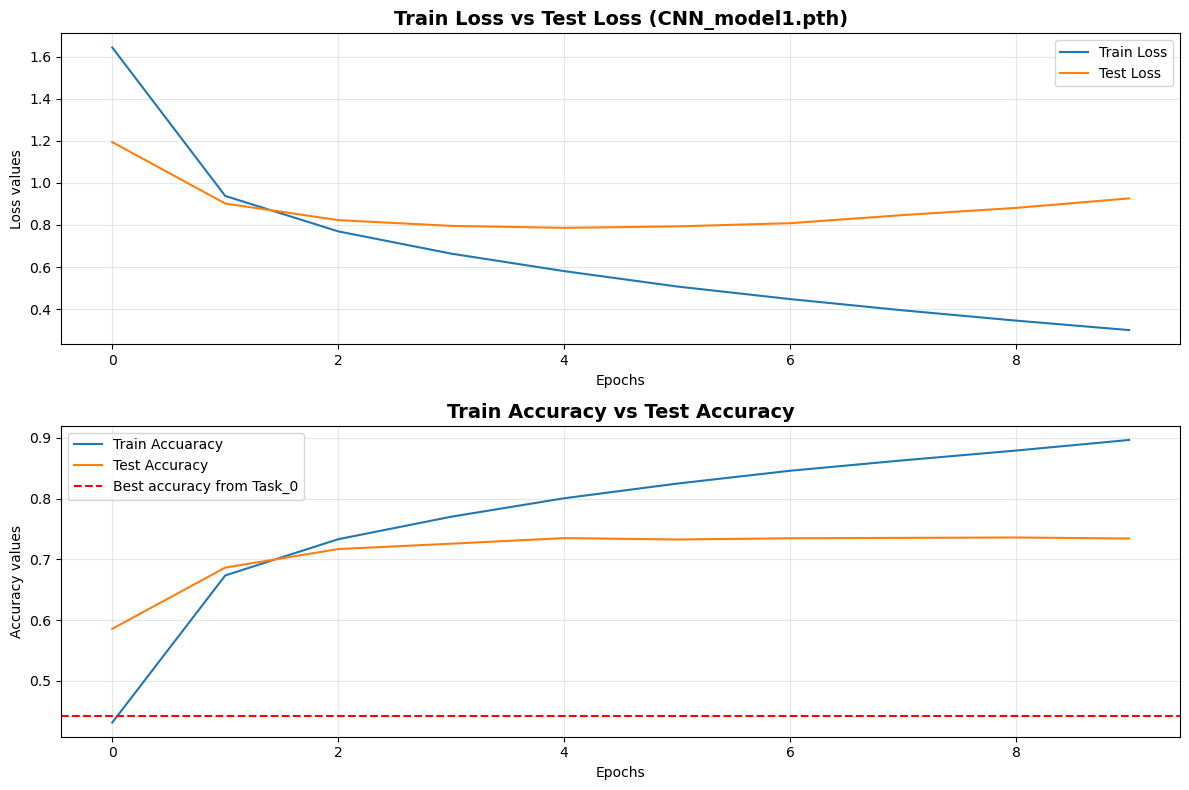

In [220]:
plot_loss_acc_fn(metrics=metrics,model_name="CNN_model1.pth")

In [221]:
# Calculate results on test dataset
CNN_model1_results = eval_model(model=CNN_model1, data_loader=test_dataloader,loss_fn=nn.CrossEntropyLoss(),accuracy_fn=accuracy_score,device=device)
CNN_model1_results

{'model_name': 'Conv_model',
 'model_loss': 0.926494836807251,
 'model_acc': 0.7343250798722045}

## 1.5 Conclusion for `CNN_model1`

- So, i used all the implementations from the best MLP that i achieved (`model5_dropout`), and unfortunately i had overfitting.
- As far as the accuracy, the result was expected. CNN models perform better in image classification problems
- Next up i will try to prevent the overfitting

## 2.1 Tune the hyperparameters of the `CNN_model1`

- Higher dropout forces the model to rely less on specific neurons and generalize better.
- Weight decay - prevents overfitting by discouraging the model from relying too heavily on large weights.
- Reduce the number of hidden units to limit model complexity, which can help avoid overfitting.

In [222]:
class CNN_model2(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()

        # First block
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second block
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape),
            nn.Dropout(0.5),  # Dropout to reduce overfitting     
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Define model and move to device
CNN_model2 = CNN_model2(input_shape=3, hidden_units=48, output_shape=len(class_names)).to(device)
CNN_model2

CNN_model2(
  (block_1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatte

## 2.2 Training and Testing loop for `CNN_model2`

In [223]:
# Measure time
train_time_start_CNN_model2 = timer()

# Train and test model 
epochs = 20

metrics = my_Metrics(epochs)

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    ls,ac = train_step(data_loader=train_dataloader, 
        model=CNN_model2, 
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(params=CNN_model2.parameters(), lr=0.001, momentum=0.7,weight_decay=1e-2),
        accuracy_fn=accuracy_score,
        device=device
    )
    metrics.train_loss_values[epoch]=ls
    metrics.train_acc_values[epoch]=ac
    ls,ac = test_step(data_loader=test_dataloader,
        model=CNN_model2,
        loss_fn=nn.CrossEntropyLoss(),
        accuracy_fn=accuracy_score,
        device=device
    )
    metrics.test_loss_values[epoch]=ls
    metrics.test_acc_values[epoch]=ac

train_time_end_CNN_model2 = timer()
train_time_CNN_model2 = train_time_end_CNN_model2-train_time_start_CNN_model2

Epoch: 0
---------
Train loss: 1.94248 | Train accuracy: 0.33
Test loss: 1.30324 | Test accuracy: 0.57

Epoch: 1
---------
Train loss: 0.99937 | Train accuracy: 0.65
Test loss: 0.91094 | Test accuracy: 0.68

Epoch: 2
---------
Train loss: 0.82407 | Train accuracy: 0.71
Test loss: 0.84958 | Test accuracy: 0.70

Epoch: 3
---------
Train loss: 0.73502 | Train accuracy: 0.75
Test loss: 0.80424 | Test accuracy: 0.72

Epoch: 4
---------
Train loss: 0.67705 | Train accuracy: 0.77
Test loss: 0.76531 | Test accuracy: 0.73

Epoch: 5
---------
Train loss: 0.63570 | Train accuracy: 0.78
Test loss: 0.76807 | Test accuracy: 0.73

Epoch: 6
---------
Train loss: 0.60290 | Train accuracy: 0.79
Test loss: 0.74705 | Test accuracy: 0.74

Epoch: 7
---------
Train loss: 0.57571 | Train accuracy: 0.80
Test loss: 0.71366 | Test accuracy: 0.75

Epoch: 8
---------
Train loss: 0.55201 | Train accuracy: 0.81
Test loss: 0.71346 | Test accuracy: 0.75

Epoch: 9
---------
Train loss: 0.53394 | Train accuracy: 0.82
Te

## 2.3 Save the `CNN_model2`

In [224]:
save_model(model=CNN_model2, model_name="CNN_model2")

Saving model to:Ex1_Models\CNN_model2


## 2.4 PLot and evaluate the `CNN_model2`

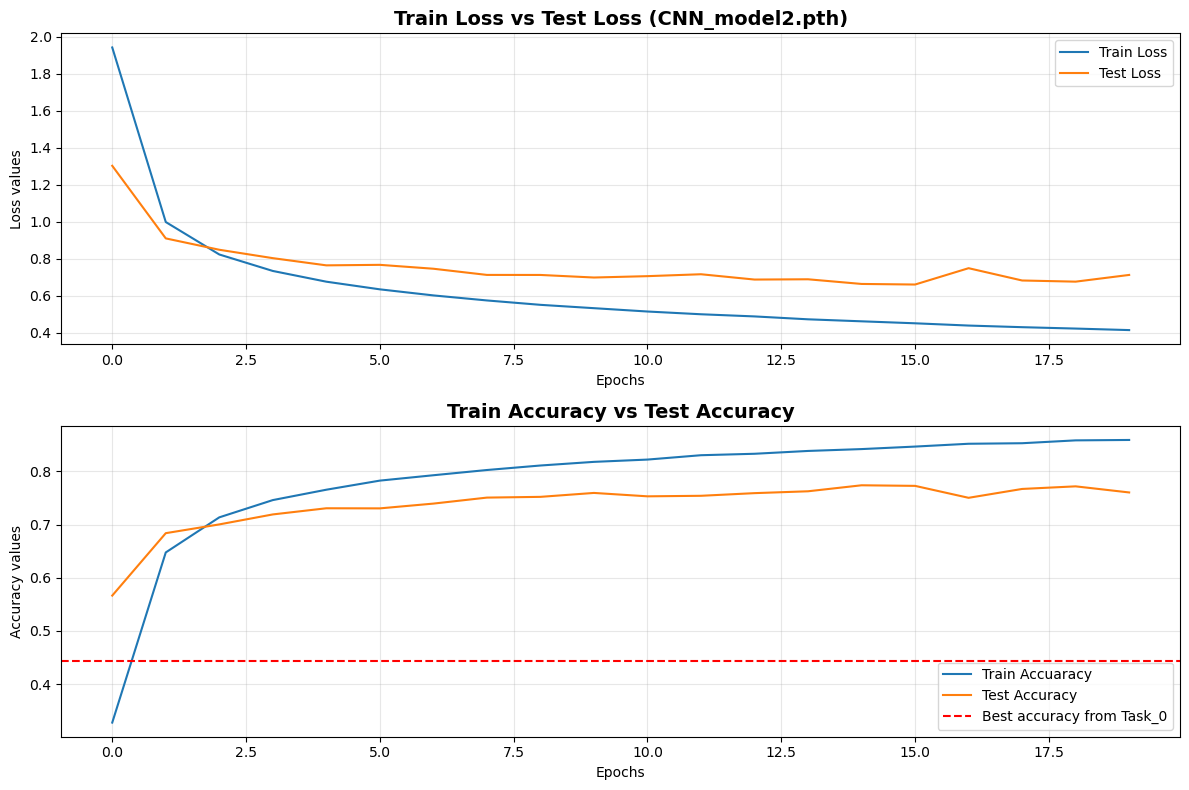

In [225]:
plot_loss_acc_fn(metrics=metrics,model_name="CNN_model2.pth")

In [226]:
CNN_model2_results = eval_model(model=CNN_model2, data_loader=test_dataloader,loss_fn=nn.CrossEntropyLoss(),accuracy_fn=accuracy_score,device=device)
CNN_model2_results

{'model_name': 'CNN_model2',
 'model_loss': 0.713542103767395,
 'model_acc': 0.7603833865814696}

## 2.5 Conclusion for `CNN_model2`

Tuning the hyperparameters like increasing the dropout, increasing the weight decay and decreasing the number of hidden units improved slightly the accuracy of my model and prevented slightly the overfitting. 

I asked ChatGPT to tell me another way to improve the accuracy and prevent the overfitting and told me to change the classifier layer by adding an additional fully connected layer with a ReLU activation. Let's see how this model performs

## 3.1 Change the classifier layer

In [227]:
class CNN_model3(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()

        # First block
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second block
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),  # Batch normalization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=hidden_units*4*4),  # Reduced size to avoid over-parameterization
            nn.ReLU(),
            nn.Dropout(0.4),  
            nn.Linear(in_features=hidden_units*4*4, out_features=output_shape)
            )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Define model and move to device
CNN_model3 = CNN_model3(input_shape=3, hidden_units=48, output_shape=len(class_names)).to(device)
CNN_model3

CNN_model3(
  (block_1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatte

## 3.2 Train and Test loop for `CNN_model3`

In [228]:
# Measure time
train_time_start_CNN_model3 = timer()

# Train and test model 
epochs = 20

metrics = my_Metrics(epochs)

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    ls,ac = train_step(data_loader=train_dataloader, 
        model=CNN_model3, 
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(params=CNN_model3.parameters(), lr=0.001, momentum=0.7,weight_decay=1e-2),
        accuracy_fn=accuracy_score,
        device=device
    )
    metrics.train_loss_values[epoch]=ls
    metrics.train_acc_values[epoch]=ac
    ls,ac = test_step(data_loader=test_dataloader,
        model=CNN_model3,
        loss_fn=nn.CrossEntropyLoss(),
        accuracy_fn=accuracy_score,
        device=device
    )
    metrics.test_loss_values[epoch]=ls
    metrics.test_acc_values[epoch]=ac

train_time_end_CNN_model3 = timer()
train_time_CNN_model3 = train_time_end_CNN_model3-train_time_start_CNN_model3

Epoch: 0
---------
Train loss: 1.41700 | Train accuracy: 0.49
Test loss: 1.11778 | Test accuracy: 0.60

Epoch: 1
---------
Train loss: 0.98515 | Train accuracy: 0.65
Test loss: 0.93323 | Test accuracy: 0.67

Epoch: 2
---------
Train loss: 0.80981 | Train accuracy: 0.71
Test loss: 0.84025 | Test accuracy: 0.71

Epoch: 3
---------
Train loss: 0.70246 | Train accuracy: 0.75
Test loss: 0.76325 | Test accuracy: 0.73

Epoch: 4
---------
Train loss: 0.62050 | Train accuracy: 0.78
Test loss: 0.71800 | Test accuracy: 0.74

Epoch: 5
---------
Train loss: 0.54957 | Train accuracy: 0.81
Test loss: 0.68186 | Test accuracy: 0.76

Epoch: 6
---------
Train loss: 0.48667 | Train accuracy: 0.83
Test loss: 0.67600 | Test accuracy: 0.76

Epoch: 7
---------
Train loss: 0.42830 | Train accuracy: 0.85
Test loss: 0.67336 | Test accuracy: 0.77

Epoch: 8
---------
Train loss: 0.36873 | Train accuracy: 0.88
Test loss: 0.65094 | Test accuracy: 0.78

Epoch: 9
---------
Train loss: 0.31711 | Train accuracy: 0.89
Te

## 3.3 Save the `CNN_model3`

In [229]:
save_model(model=CNN_model3, model_name="CNN_model3.pth")

Saving model to:Ex1_Models\CNN_model3.pth


## 3.4 Plot and evaluate the `CNN_model3`

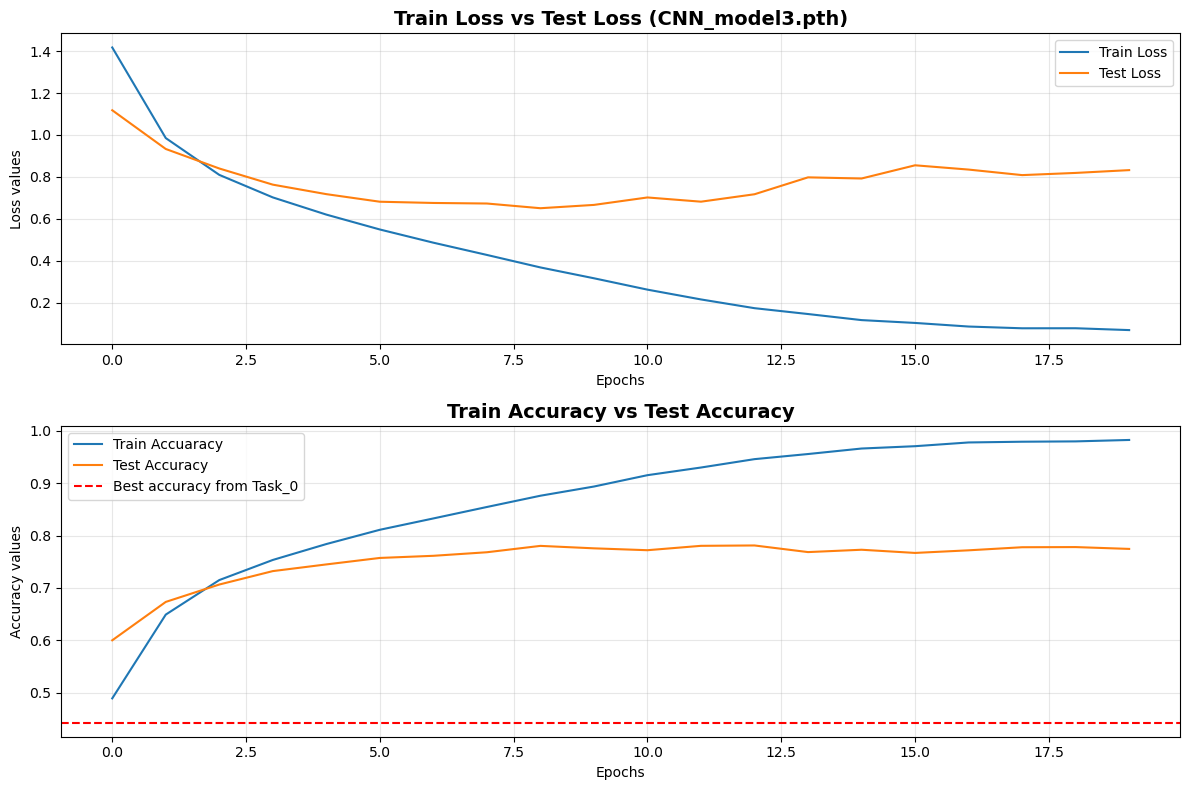

In [230]:
plot_loss_acc_fn(metrics=metrics,model_name="CNN_model3.pth")

In [231]:
CNN_model3_results = eval_model(model=CNN_model3, data_loader=test_dataloader,loss_fn=nn.CrossEntropyLoss(),accuracy_fn=accuracy_score,device=device)
CNN_model3_results

{'model_name': 'CNN_model3',
 'model_loss': 0.832487165927887,
 'model_acc': 0.7745607028753994}

## 3.5 Conclusion for `CNN_model3`

As i am seeing from the graphs, my attempt to increase the accuracy of the previous model (`CNN_model2`) wasn't very successfull, because sometimes a got better accuracy and sometimes i got worse. Also the overfitting was worse in this attempt

## Conclusion for CNN models

As expected the CNN models achieved better accuracy than the MLP models (because we have an image classification problem )and both were better than the KNN and NCC classifiers.

I also wanted to try some other things to improve me CNN models like:
* Data Augmentation, which would artificially increase the size of the dataset by applying transformations like flipping, rotation, ...
  I believe that this techique would make my model more robust and reduce the overfitting.

* Experiment more with the structure of the MLP model. Make it more complicated, but not necessary wider and deeper

In [232]:
compare_results = pd.DataFrame([CNN_model1_results, CNN_model2_results, CNN_model3_results])
compare_results["training_time"] = [train_time_CNN_model1,
                                    train_time_CNN_model2,
                                    train_time_CNN_model3]

compare_results

,model_name,model_loss,model_acc,training_time
0,Conv_model,0.926495,0.734325,113.280295
1,CNN_model2,0.713542,0.760383,190.914373
2,CNN_model3,0.832487,0.774561,214.929755


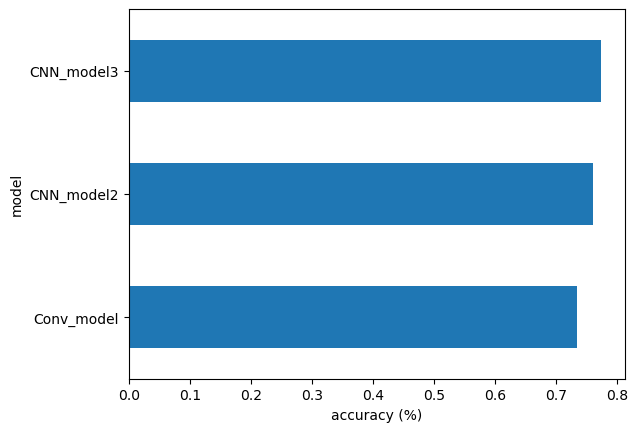

In [233]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

From the above i can say that all the CNN models that i created have similar accuracy values, but i think that the best one is `CNN_model2` because it has  a good balance between loss, accuracy, and training time.

Next up i am showing the confusion matrix for `CNN_model2`.

Confusion matrix provides a detailed breakdown of the model's predictions across all classes, helping me identify strengths and weaknesses in the classification problem.







 

## Confusion matrix for the best model

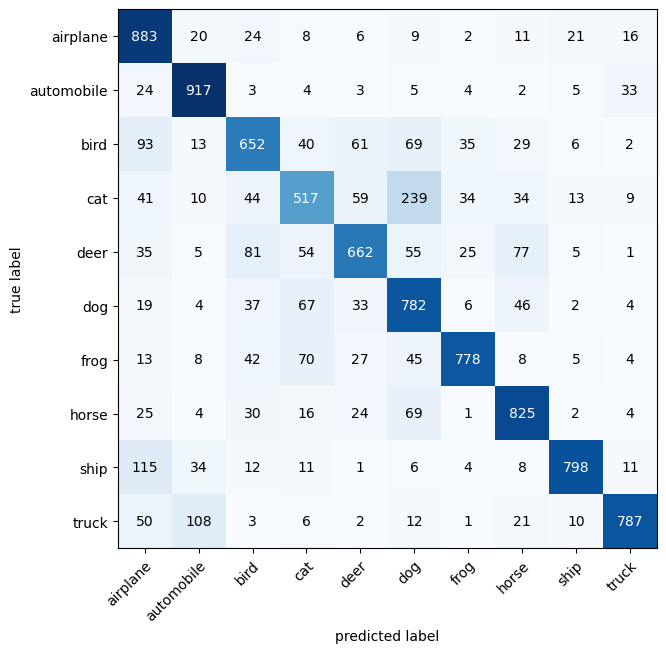

In [234]:
y_preds = []
y_tests=[]
CNN_model2.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X=X.to(device)
        y=y.to(device)
        # Do the forward pass
        y_logit=CNN_model2(X)
        # get the perdiction labels
        y_pred = y_logit.argmax(dim=1)
        y_preds.append(y_pred.cpu())
        y_tests.append(y.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_test_tensor = torch.cat(y_tests)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);
        
    

- From the confusion matrix, i am seeing that for the class `cat` the predicted labels are correct only the half of the times, which isn't good.
- `Deer` class has only 662 out of 1000 correct predictions.
- All the other classes are close to 80% or higher

# Conclusion for task_1

From the above i can say with certainty that for a classification problem like the CIFAR-10, i would choose a Neural Network over the classifier algorythms which we implemented in task_0 and more specifically a CNN

ΧΡΗΣΤΟΣ ΚΟΥΝΣΟΛΑΣ
10345
ΤΗΜΜΥ